In [8]:
# run initial imports
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from scipy.integrate import odeint
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from mpl_toolkits.basemap import Basemap
import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics 

from fbprophet import Prophet

from ipywidgets import widgets

from fbprophet.plot import plot_plotly
import plotly.offline as py

from datetime import datetime

In [9]:
NOW = datetime.now()

In [10]:
#setup initial data frames
input_dir = "./data/"
covid_19_ts = pd.read_csv(input_dir + 'covid_19_ts.csv')
covid_19_national_observations = pd.read_csv(input_dir + 'global/covid_19_national_observations.csv')
covid_19_infected_observations = pd.read_csv(input_dir + 'global/covid_19_infected_observations.csv')
covid_19_world_totals = pd.read_csv(input_dir + 'global/covid_19_world_totals.csv')

In [11]:
#correct date parsing on some of the JH data
covid_19_ts['Date'] = pd.to_datetime(covid_19_ts['Date'])
covid_19_national_observations['Date'] = pd.to_datetime(covid_19_national_observations['Date'])
covid_19_infected_observations['Date'] = pd.to_datetime(covid_19_infected_observations['Date'])
covid_19_world_totals['Date'] = pd.to_datetime(covid_19_world_totals['Date'])

In [12]:
#covid_19_infected_observations = covid_19_infected_observations.sort_values(['Country/Region', 'Day'])
#covid_19_national_observations = covid_19_national_observations.sort_values(['Country/Region', 'Date'])

In [13]:
#quick national overview

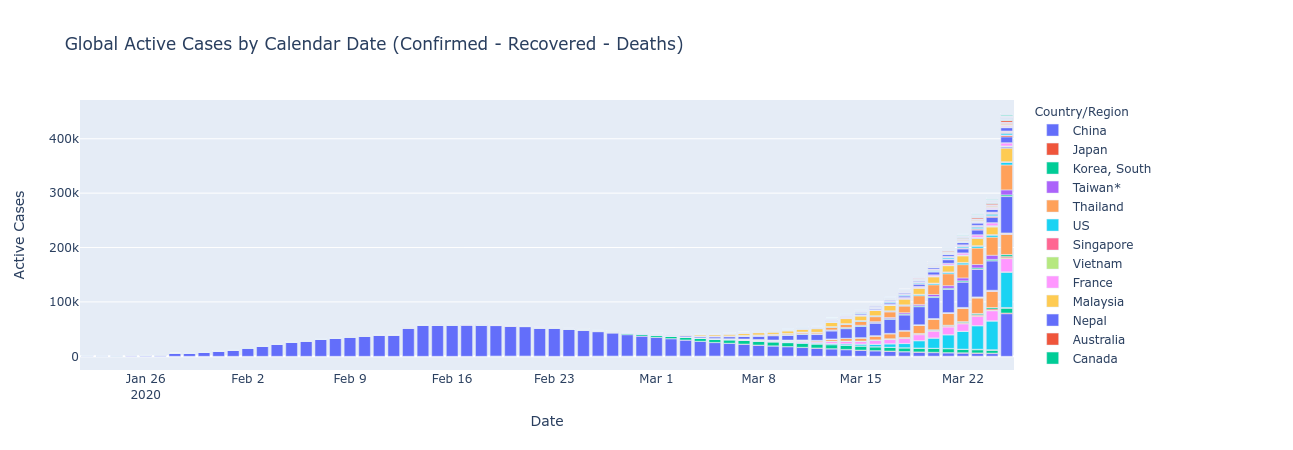

In [14]:
world_chart = px.bar(covid_19_national_observations, 
    x="Date", y="Active Cases", color="Country/Region", title="Global Active Cases by Calendar Date (Confirmed - Recovered - Deaths)")
world_chart.show()

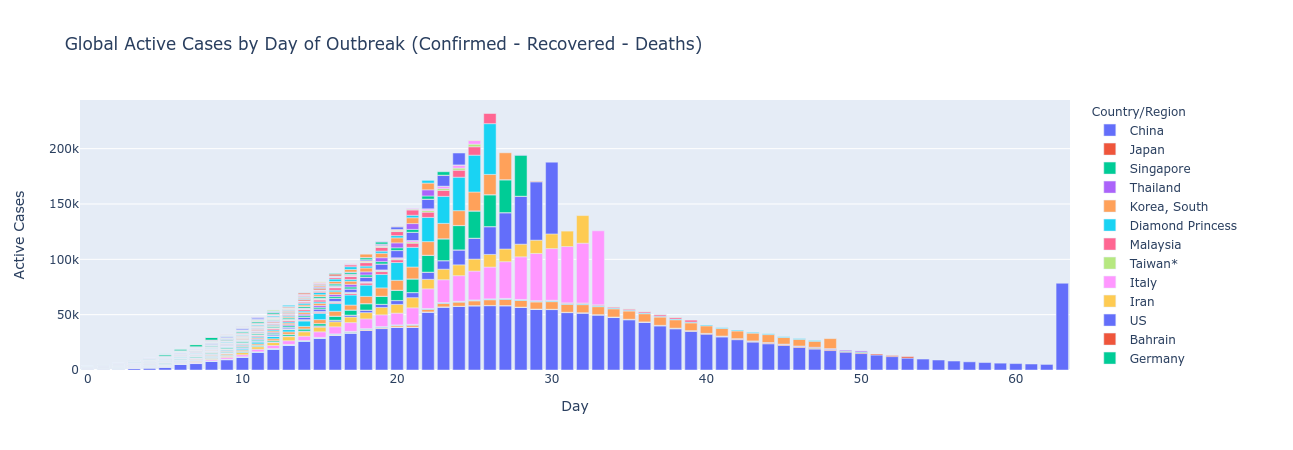

In [15]:
world_chart = px.bar(covid_19_infected_observations, 
    x="Day", y="Active Cases", color="Country/Region", title="Global Active Cases by Day of Outbreak (Confirmed - Recovered - Deaths)")
world_chart.show()
world_chart.write_html('./www//global_by_day.html')

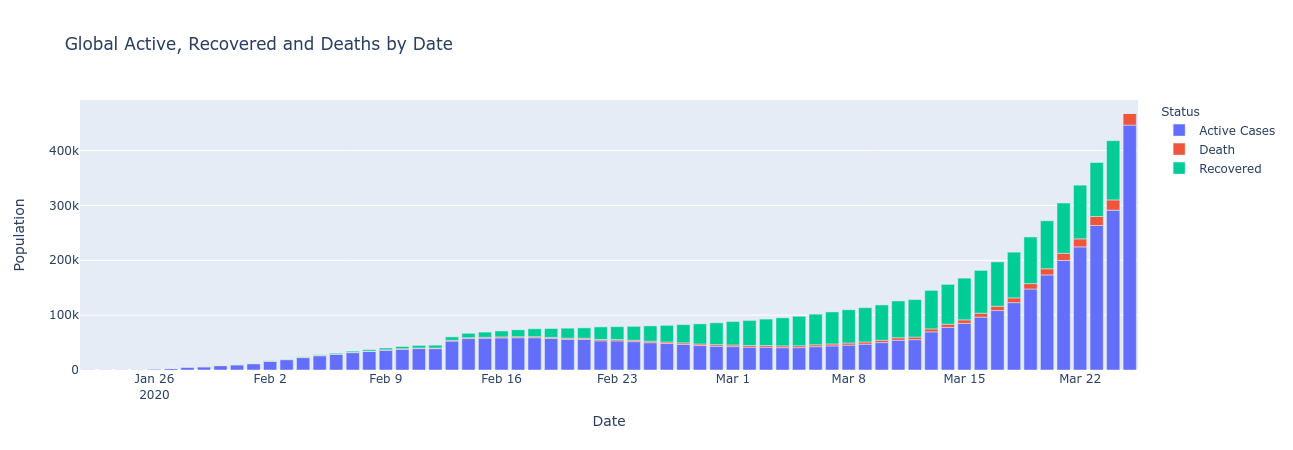

In [16]:
covid_19_world_totals_state = covid_19_world_totals[['Date', 'Active Cases', 'Recovered', 'Death']].melt(id_vars=['Date'], 
            value_vars=['Active Cases', 'Death', 'Recovered'], value_name="Population", var_name='Status')
world_chart = px.bar(covid_19_world_totals_state, 
    x="Date", y="Population", color="Status", title="Global Active, Recovered and Deaths by Date")
world_chart.show()
world_chart.write_image('./www/global.png')

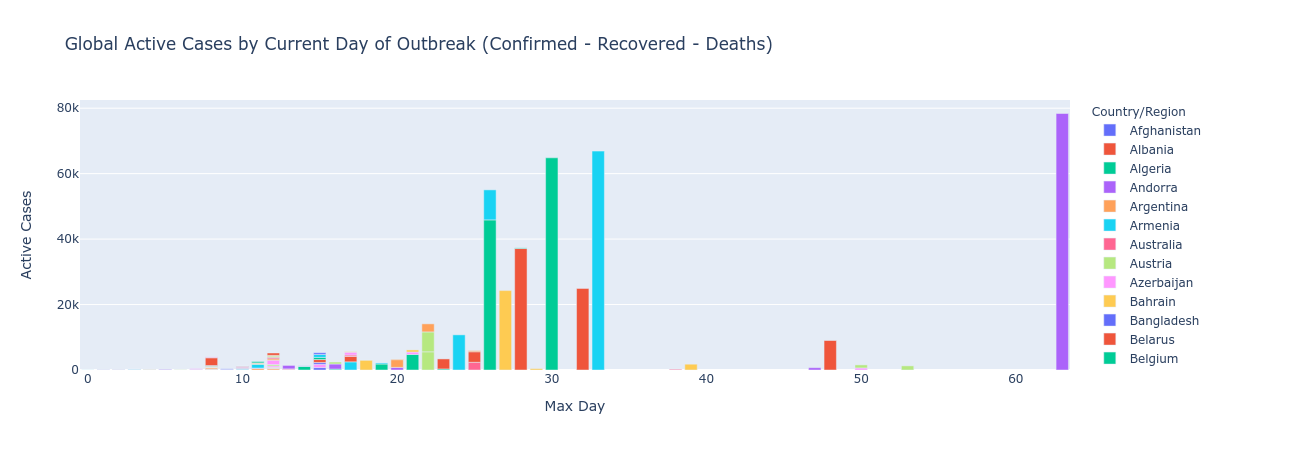

In [17]:
max_df = covid_19_infected_observations.groupby(['Country/Region', 'Max Day']).last().reset_index()
world_chart = px.bar(max_df, 
    x="Max Day", y="Active Cases", color="Country/Region", title="Global Active Cases by Current Day of Outbreak (Confirmed - Recovered - Deaths)")
world_chart.show()

In [18]:
cn_df = covid_19_national_observations.copy()
cn_df = cn_df[cn_df['Country/Region'] == 'China']

In [19]:
cn_df['Death'].max() / (cn_df['Active Cases'].max() * 1.14) 

0.03676608843738416

In [20]:
countries = covid_19_national_observations.groupby('Country/Region')

In [21]:
#select a single from group
#countries.get_group('China')

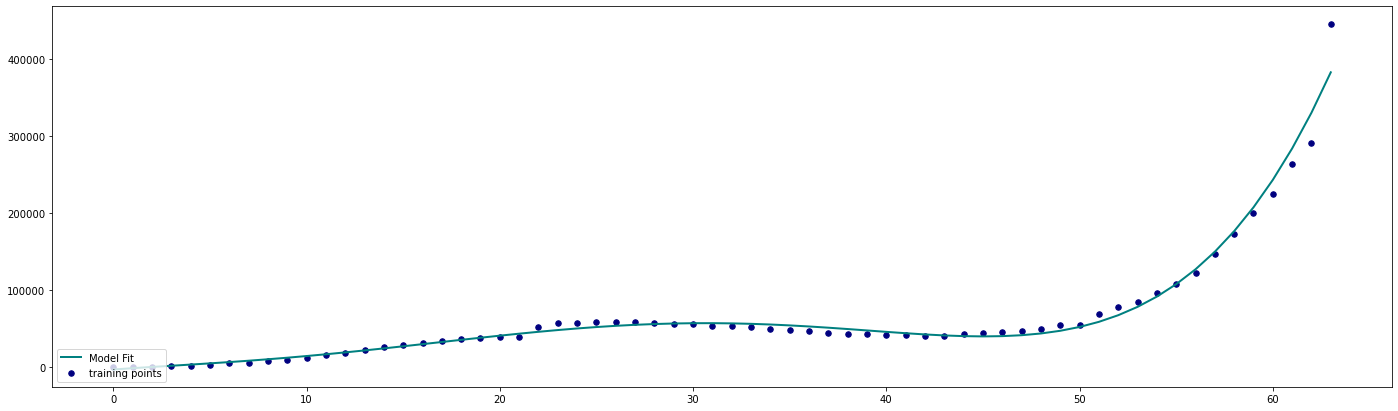

In [22]:
fDay=3

covid_19_world_totals=covid_19_world_totals.sort_values('Date')
covid_19_world_totals=covid_19_world_totals.reset_index(drop=True)
covid_19_world_totals['Day'] = covid_19_world_totals.index
x=covid_19_world_totals.index
y=covid_19_world_totals['Active Cases']

x_plot = x

# create matrix versions of these arrays
X = x[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]

colors = ['teal', 'yellowgreen', 'gold']
lw = 2

plt.figure(figsize=(24,7))
#plt.plot(x, y, color='cornflowerblue', linewidth=lw,
#         label="ground truth")
plt.scatter(x, y, color='navy', s=30, marker='o', label="training points")

for count, degree in enumerate([5]):
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(X, y)
    y_plot = model.predict(X_plot)
    plt.plot(x_plot, y_plot, color=colors[count], linewidth=lw,
             label="Model Fit")

plt.legend(loc='lower left')

plt.show()

In [23]:
fb_df = covid_19_world_totals[['Date', 'Active Cases']].copy()
fb_df = fb_df.sort_values('Date').reset_index(drop=True)
fb_df.columns = ['ds','y']
#print(fb_df)

m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, growth='linear', n_changepoints=3)
m.fit(fb_df)

future = m.make_future_dataframe(periods=3)

forecast = m.predict(future)

In [24]:
# uncomment to see the raw plot components
# fig2 = m.plot_components(forecast)

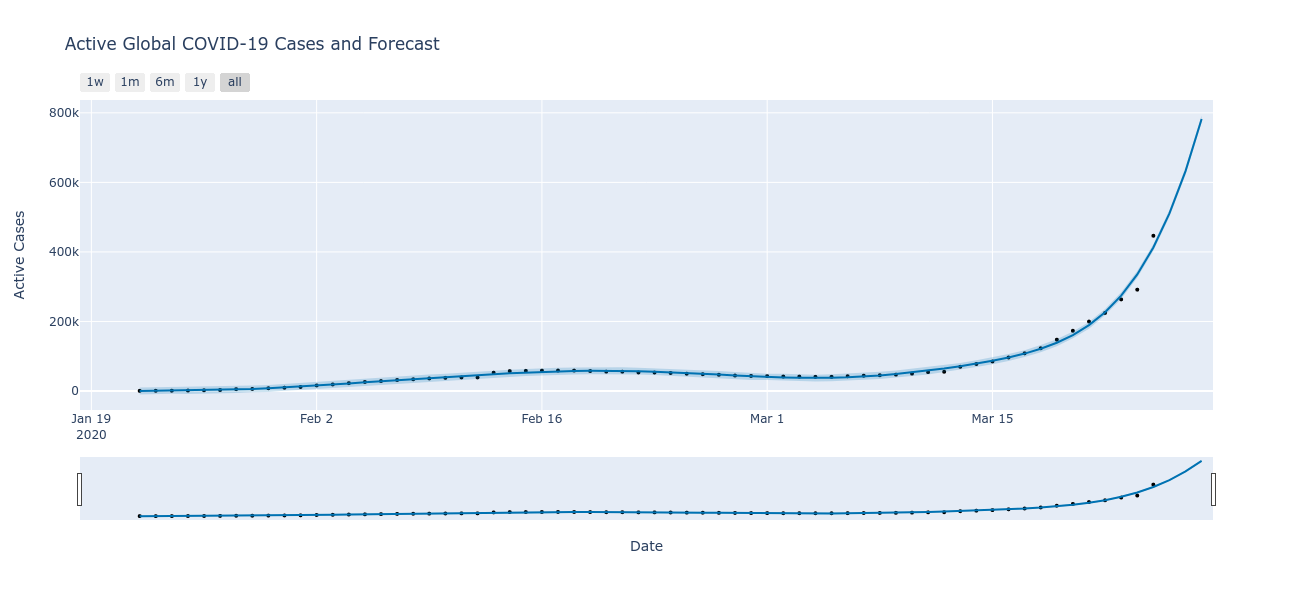

In [25]:
py.init_notebook_mode()

fig = plot_plotly(m, forecast, xlabel='Date', ylabel='Active Cases', uncertainty=True, figsize=(1200,600))  # This returns a plotly Figure
fig.update_layout(title='Active Global COVID-19 Cases and Forecast')
py.iplot(fig)
#fig.write_html('./www/global_forecast.html')

In [26]:
cluster_df = covid_19_infected_observations[['Day', 'Active Cases', 'Death', 'Recovered']]

cluster_df = MinMaxScaler().fit_transform(cluster_df)
db = DBSCAN(eps=0.01, min_samples=5).fit(cluster_df)
labels = db.labels_
covid_19_infected_observations['ClusterDB'] = labels

cluster_df = pd.DataFrame(cluster_df)
cluster_df.columns = ['Day', 'Active Cases', 'Death', 'Recovered']
covid_19_infected_observations['Active Score'] = cluster_df['Active Cases']
covid_19_infected_observations['Death Score'] = cluster_df['Death']

cluster_df_days = covid_19_infected_observations[['Day', 'Max Day', 'Active Cases', 'Death', 'Recovered']]

cluster_df_days = MinMaxScaler().fit_transform(cluster_df_days)
db = DBSCAN(eps=0.025, min_samples=3).fit(cluster_df_days)
labels = db.labels_
covid_19_infected_observations['ClusterDBDays'] = labels

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4eb60dcd90>]],
      dtype=object)

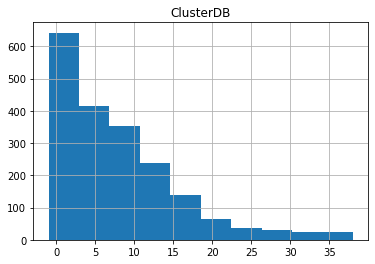

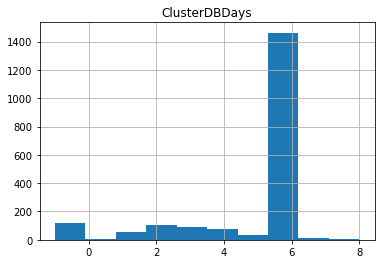

In [27]:
covid_19_infected_observations[['ClusterDB', 'Country/Region']].hist()
covid_19_infected_observations[['ClusterDBDays', 'Country/Region']].hist()

In [28]:
cluster_plot_df = covid_19_infected_observations[['Country/Region', 'ClusterDB', 'ClusterDBDays', 'Active Cases', 'Death', 'Max Day']].copy().groupby('Country/Region').mean().reset_index()

In [29]:
# show 3d cluster
# cluster_plot_3d = px.scatter_3d(cluster_plot_df, x = 'ClusterDB', y='ClusterDBDays', z='Active Cases', color='Country/Region')
# cluster_plot_3d.update_layout(
#     width=1200, height=700
# )
# cluster_plot_3d.show()

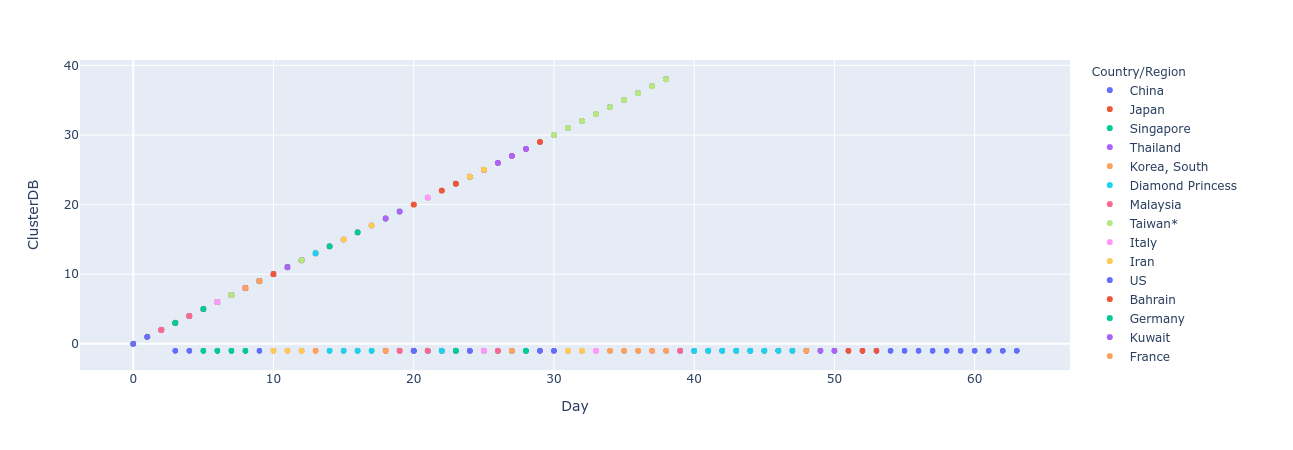

In [30]:
cluster_plot = px.scatter(covid_19_infected_observations, x = 'Day', y='ClusterDB', color='Country/Region',  log_y=False)
cluster_plot.show()

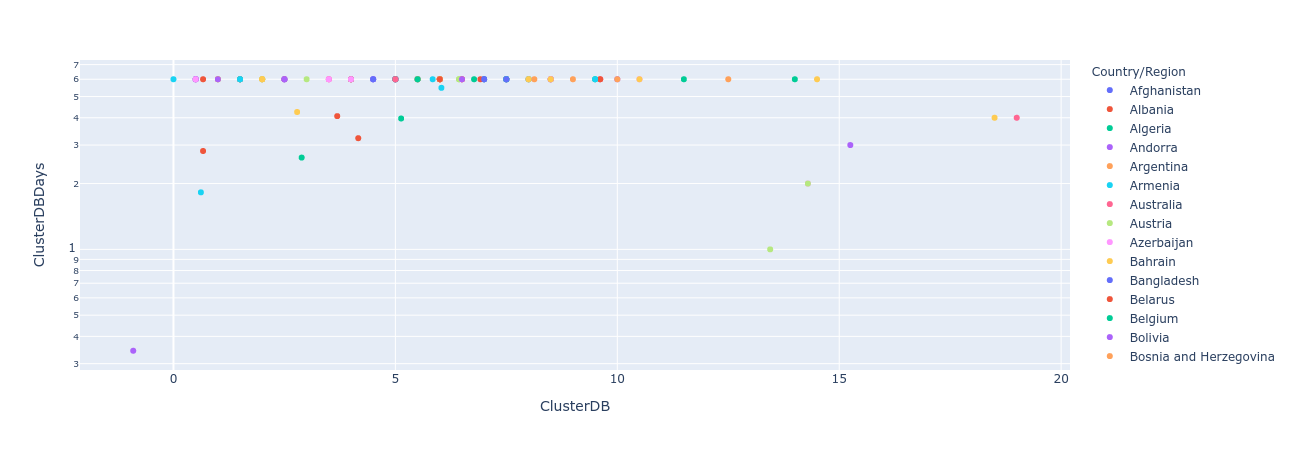

In [31]:
cluster_plot = px.scatter(cluster_plot_df, x = 'ClusterDB', y='ClusterDBDays', color='Country/Region',  log_y=True)
cluster_plot.show()

In [32]:
cluster_groups = covid_19_infected_observations.groupby(['ClusterDB'])

In [33]:
pd.set_option('display.max_rows', 500)
cluster_groups.head(500)

Date  Country/Region  Confirmed  Death  Recovered  Day  \
0    2020-01-22           China      548.0   17.0       28.0    0   
1    2020-01-23           China      643.0   18.0       30.0    1   
2    2020-01-24           China      920.0   26.0       36.0    2   
3    2020-01-25           China     1406.0   42.0       39.0    3   
4    2020-01-26           China     2075.0   56.0       49.0    4   
...         ...             ...        ...    ...        ...  ...   
1960 2020-03-25  United Kingdom     9640.0  466.0        0.0   26   
1961 2020-03-25         Uruguay      189.0    0.0        0.0    8   
1962 2020-03-25      Uzbekistan       60.0    0.0        0.0    6   
1963 2020-03-25       Venezuela       91.0    0.0        0.0    8   
1964 2020-03-25         Vietnam      141.0    0.0        0.0   17   

      Active Cases  Likely Cases 1pct  Likely Cases 1.8pct  \
0            503.0             1700.0               3060.0   
1            595.0             1800.0               3240.0   
2            858.0             2600.0               4680.0   
3           1325.0             4200.0               7560.0   
4           1970.0             5600.0              10080.0   
...            ...                ...                  ...   
1960        9174.0            46600.0              83880.0   
1961         189.0                0.0                  0.0   
1962          60.0                0.0                  0.0   
1963          91.0                0.0                  0.0   
1964         141.0                0.0                  0.0   

      Likely Cases 3.5pct  Death Rate  Death Change Rate  \
0                  5950.0       0.031                NaN   
1                  6300.0       0.028           0.058824   
2                  9100.0       0.028           0.444444   
3                 14700.0       0.030           0.615385   
4                 19600.0       0.027           0.333333   
...                   ...         ...                ...   
1960             163100.0       0.048           0.101655   
1961                  0.0       0.000                NaN   
1962                  0.0       0.000                NaN   
1963                  0.0       0.000                NaN   
1964                  0.0       0.000                NaN   

      Recovery Change Rate  Confirmed Change Rate          Case Bins  Max Day  \
0                      NaN                    NaN     (378.8, 759.6]       63   
1                 0.071429               0.173358     (378.8, 759.6]       63   
2                 0.200000               0.430793    (759.6, 3411.2]       63   
3                 0.083333               0.528261    (759.6, 3411.2]       63   
4                 0.256410               0.475818    (759.6, 3411.2]       63   
...                    ...                    ...                ...      ...   
1960             -1.000000               0.180794  (3411.2, 78376.0]       26   
1961                   NaN               0.166667     (116.0, 197.0]        8   
1962                   NaN               0.200000       (51.0, 75.0]        6   
1963             -1.000000               0.083333      (75.0, 116.0]        8   
1964             -1.000000               0.052239     (116.0, 197.0]       17   

      ClusterDB  Active Score  Death Score  ClusterDBDays  
0             0      0.006367     0.002266              0  
1             1      0.007541     0.002399              0  
2             2      0.010897     0.003465              0  
3            -1      0.016856     0.005598              0  
4            -1      0.025085     0.007464              0  
...         ...           ...          ...            ...  
1960         -1      0.117006     0.062108             -1  
1961          8      0.002361     0.000000              6  
1962          6      0.000715     0.000000              6  
1963          8      0.001110     0.000000              6  
1964         17      0.001748     0.000000              6  

[1965 rows x 20 column

In [34]:
# cluster_km = KMeans(n_clusters=3)
# cluster_km.fit(cluster_df)
# labels = cluster_km.labels_
# covid_19_infected_observations['ClusterK5'] = labels

In [35]:
# cluster_plot_df = covid_19_infected_observations[['Country/Region', 'ClusterK5', 'ClusterDB', 'Active Cases', 'Death']].copy().groupby('Country/Region').max().reset_index()
# cluster_plot_3d = px.scatter_3d(cluster_plot_df, x = 'ClusterK5', y='Active Cases', z='Death', color='Country/Region')
# #cluster_plot_3d.show()

In [36]:
# # let's show why kmeans/kmediods isn't sufficient for clustering this stuff
# cluster_plot = px.scatter(cluster_plot_df, x='ClusterK5', y='ClusterDB', color='Country/Region')
# cluster_plot.show()

In [37]:
web_cases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases.csv')
web_cases['Last_Update'] = pd.to_datetime(web_cases['Last_Update'])
case_groups = web_cases.groupby(['Lat','Long_'])

In [38]:
forecasts = pd.DataFrame()
for _, g in case_groups:
    tdf = g.copy()
    fb_df = tdf[['Last_Update', 'Active']]
    fb_df = fb_df.sort_values('Last_Update').reset_index(drop=True)
    fb_df.columns = ['ds','y']
    if fb_df.shape[0] < 5:
        continue
    fb_df['floor'] = 0
    

    m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, growth='linear')
    m.fit(fb_df)
    future = m.make_future_dataframe(periods=3)
    future['floor'] = 0
    forecast = m.predict(future)
    print(forecast)
    break
    

INFO:fbprophet:n_changepoints greater than number of observations. Using 20.


                    ds        trend   yhat_lower   yhat_upper  trend_lower  \
0  2020-03-26 16:13:18     0.055751   -21.521522    29.786990     0.055751   
1  2020-03-26 16:13:34    -0.363910   -21.408515    31.192922    -0.363910   
2  2020-03-26 16:13:34    -0.363910   -21.184081    27.277359    -0.363910   
3  2020-03-26 16:13:34    -0.363910   -20.126378    29.503524    -0.363910   
4  2020-03-26 16:13:34    -0.363910   -21.012955    30.253622    -0.363910   
5  2020-03-26 16:13:34    -0.363910   -20.915164    29.508325    -0.363910   
6  2020-03-26 16:13:34    -0.363910   -21.322176    30.186015    -0.363910   
7  2020-03-26 16:13:34    -0.363910   -20.124826    29.255801    -0.363910   
8  2020-03-26 16:13:34    -0.363910   -19.648323    29.887340    -0.363910   
9  2020-03-26 16:13:34    -0.363910   -19.205712    29.697372    -0.363910   
10 2020-03-26 16:13:34    -0.363910   -19.021678    28.282364    -0.363910   
11 2020-03-26 16:13:34    -0.363910   -20.378081    30.864761   